In [5]:
import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages')

In [1]:
import numpy as np
import os
from sklearn.model_selection import KFold # had to do pip install sklearn in this notebook
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, f1_score
import itertools as it
import matplotlib.pyplot as plt

# Obtaining and Normalizing the Data

In [2]:
data = './data'
num_features_selected = 214

In [3]:
SUBJECT_NUM = 40
VIDEO_NUM = 16
SAMPLE_RATE = 128.
MISSING_DATA_SUBJECT = [9, 12, 21, 22, 23, 24, 33]

In [4]:
amigos_data = np.loadtxt(os.path.join(data, 'features.csv'), delimiter=',')

In [5]:
amigos_data.shape

(528, 215)

In [6]:
# 1st column of labels is arousal labels, 2nd column is valence labels. 
# Labels are chunked into SUBJECT_NUM-len(MISSING_DATA_SUBJECT) chunks of size VIDEO_NUM
# Discretizing all the labels, downsampling to 1 label per amigos_data datapoint

labels = np.loadtxt(os.path.join(data, 'label.csv'), delimiter=',')[:, :2]
a_labels, v_labels = [], []
for i in range(SUBJECT_NUM):
    if i + 1 in MISSING_DATA_SUBJECT:
        continue
    a_labels_mean = np.mean(labels[i * VIDEO_NUM:i * VIDEO_NUM + VIDEO_NUM, 0])
    v_labels_mean = np.mean(labels[i * VIDEO_NUM:i * VIDEO_NUM + VIDEO_NUM, 1])
    for idx, label in enumerate(labels[i * VIDEO_NUM:i * VIDEO_NUM + VIDEO_NUM, :]):
        a_tmp = 1 if label[0] > a_labels_mean else 0
        v_tmp = 1 if label[1] > v_labels_mean else 0
        a_labels.append(a_tmp)
        v_labels.append(v_tmp)
a_labels, v_labels = np.array(a_labels), np.array(v_labels)

In [7]:
v_labels.shape

(528,)

In [8]:
# Fit features within a range
amigos_data_max = np.max(amigos_data, axis=0)
amigos_data_min = np.min(amigos_data, axis=0)
amigos_data_normalized = (amigos_data - amigos_data_min) / (amigos_data_max - amigos_data_min)
amigos_data_normalized = amigos_data_normalized * 2 - 1

In [9]:
# setup classifier
a_clf = SVC(C=0.75, kernel='linear')
v_clf = SVC(C=0.2, kernel='linear')

In [10]:
# setup RFE feature selection
a_clf_select = RFE(a_clf, num_features_selected, verbose=0)
v_clf_select = RFE(v_clf, num_features_selected, verbose=0)

C:\Users\hydsu\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=214 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


# Cross Validation
To verify accuracy matches Baseline SVM. 
(Only difference from Baseline is we normalize the whole data, instead of normalizing training/testing separately for each fold)

In [11]:
# setup kfold cross validator
kfold = KFold(n_splits=SUBJECT_NUM - len(MISSING_DATA_SUBJECT))

In [12]:
train_a_accuracy_history = []
train_v_accuracy_history = []
train_a_f1score_history = []
train_v_f1score_history = []
val_a_accuracy_history = []
val_v_accuracy_history = []
val_a_f1score_history = []
val_v_f1score_history = []
a_idx_history = np.zeros(amigos_data_normalized.shape[1])
v_idx_history = np.zeros(amigos_data_normalized.shape[1])

In [13]:
for idx, (train_idx, val_idx) in enumerate(kfold.split(amigos_data_normalized)):
    print(idx + 1, 'Fold Start')

    # collect data for cross validation
    train_data, val_data = amigos_data_normalized[train_idx], amigos_data_normalized[val_idx]
    train_a_labels, val_a_labels = a_labels[train_idx], a_labels[val_idx]
    train_v_labels, val_v_labels = v_labels[train_idx], v_labels[val_idx]
        
    # fit feature selection
    a_clf_select.fit(train_data, train_a_labels)
    v_clf_select.fit(train_data, train_v_labels)
    train_a_data = a_clf_select.transform(train_data)
    train_v_data = v_clf_select.transform(train_data)
    val_a_data = a_clf_select.transform(val_data)
    val_v_data = v_clf_select.transform(val_data)
    a_idx = np.where(a_clf_select.ranking_ == 1)
    v_idx = np.where(v_clf_select.ranking_ == 1)
        
    # fit classifier
    a_clf.fit(train_a_data, train_a_labels)
    v_clf.fit(train_v_data, train_v_labels)

    # predict arousal and valence
    train_a_predict_labels = a_clf.predict(train_a_data)
    train_v_predict_labels = v_clf.predict(train_v_data)
    val_a_predict_labels = a_clf.predict(val_a_data)
    val_v_predict_labels = v_clf.predict(val_v_data)

    # metrics (accuracy and f1 score) calculation
    train_a_accuracy = accuracy_score(train_a_labels, train_a_predict_labels)
    train_v_accuracy = accuracy_score(train_v_labels, train_v_predict_labels)
    train_a_f1score = f1_score(train_a_labels, train_a_predict_labels, average='macro')
    train_v_f1score = f1_score(train_v_labels, train_v_predict_labels, average='macro')
    val_a_accuracy = accuracy_score(val_a_labels, val_a_predict_labels)
    val_v_accuracy = accuracy_score(val_v_labels, val_v_predict_labels)
    val_a_f1score = f1_score(val_a_labels, val_a_predict_labels, average='macro')
    val_v_f1score = f1_score(val_v_labels, val_v_predict_labels, average='macro')

    train_a_accuracy_history.append(train_a_accuracy)
    train_v_accuracy_history.append(train_v_accuracy)
    train_a_f1score_history.append(train_a_f1score)
    train_v_f1score_history.append(train_v_f1score)
    val_a_accuracy_history.append(val_a_accuracy)
    val_v_accuracy_history.append(val_v_accuracy)
    val_a_f1score_history.append(val_a_f1score)
    val_v_f1score_history.append(val_v_f1score)

    print('Training Result')
    print("Arousal: Accuracy: {:.4f}, F1score: {:.4f}".format(train_a_accuracy, train_a_f1score))
    print("Valence: Accuracy: {:.4f}, F1score: {:.4f}".format(train_v_accuracy, train_v_f1score))
    print('Validating Result')
    print("Arousal: Accuracy: {:.4f}, F1score: {:.4f}".format(val_a_accuracy, val_a_f1score))
    print("Valence: Accuracy: {:.4f}, F1score: {:.4f}".format(val_v_accuracy, val_v_f1score))

1 Fold Start
Training Result
Arousal: Accuracy: 0.9082, F1score: 0.9081
Valence: Accuracy: 0.9531, F1score: 0.9530
Validating Result
Arousal: Accuracy: 0.8750, F1score: 0.8730
Valence: Accuracy: 0.9375, F1score: 0.9373
2 Fold Start
Training Result
Arousal: Accuracy: 0.9180, F1score: 0.9179
Valence: Accuracy: 0.9551, F1score: 0.9550
Validating Result
Arousal: Accuracy: 0.7500, F1score: 0.7460
Valence: Accuracy: 0.8750, F1score: 0.8750
3 Fold Start
Training Result
Arousal: Accuracy: 0.9121, F1score: 0.9120
Valence: Accuracy: 0.9531, F1score: 0.9530
Validating Result
Arousal: Accuracy: 1.0000, F1score: 1.0000
Valence: Accuracy: 0.9375, F1score: 0.9352
4 Fold Start
Training Result
Arousal: Accuracy: 0.9082, F1score: 0.9082
Valence: Accuracy: 0.9512, F1score: 0.9510
Validating Result
Arousal: Accuracy: 1.0000, F1score: 1.0000
Valence: Accuracy: 0.9375, F1score: 0.9373
5 Fold Start
Training Result
Arousal: Accuracy: 0.9258, F1score: 0.9257
Valence: Accuracy: 0.9512, F1score: 0.9511
Validatin

In [14]:
print('\nAverage Training Result')
print("Arousal => Accuracy: {:.4f}, F1score: {:.4f}".format(
    np.mean(train_a_accuracy_history), np.mean(train_a_f1score_history)))
print("Valence => Accuracy: {:.4f}, F1score: {:.4f}".format(
    np.mean(train_v_accuracy_history), np.mean(train_v_f1score_history)))
print('Average Validating Result')
print("Arousal => Accuracy: {:.4f}, F1score: {:.4f}".format(
    np.mean(val_a_accuracy_history), np.mean(val_a_f1score_history)))
print("Valence => Accuracy: {:.4f}, F1score: {:.4f}\n".format(
    np.mean(val_v_accuracy_history), np.mean(val_v_f1score_history)))


Average Training Result
Arousal => Accuracy: 0.9131, F1score: 0.9130
Valence => Accuracy: 0.9542, F1score: 0.9541
Average Validating Result
Arousal => Accuracy: 0.8068, F1score: 0.7835
Valence => Accuracy: 0.9280, F1score: 0.9257



# Training

In [15]:
# Split training/testing data
v_X_train, v_X_test, v_y_train, v_y_test = train_test_split(amigos_data_normalized, v_labels, test_size=0.3, random_state=109)
a_X_train, a_X_test, a_y_train, a_y_test = train_test_split(amigos_data_normalized, a_labels, test_size=0.3, random_state=109)

In [16]:
# fit feature selection
v_clf_select.fit(v_X_train, v_y_train)
a_clf_select.fit(a_X_train, a_y_train)
v_X_train = v_clf_select.transform(v_X_train)
a_X_train = a_clf_select.transform(a_X_train)
v_X_test = v_clf_select.transform(v_X_test)
a_X_test = a_clf_select.transform(a_X_test)
v_idx = np.where(v_clf_select.ranking_ == 1)
a_idx = np.where(a_clf_select.ranking_ == 1)

In [17]:
# fit classifier
v_clf.fit(v_X_train, v_y_train)
a_clf.fit(a_X_train, a_y_train)

SVC(C=0.75, kernel='linear')

# Preprocessing Step to Obtain alpha, support, and intercept Vectors

In [18]:
# Obtaining alphas, supports, and intercepts. 
# Since we aren't doing multi-class, we don't need to preprocess the alphas at all!

v_alpha_vector = v_clf.dual_coef_
v_supports = v_clf.support_vectors_
v_intercept = v_clf.intercept_

a_alpha_vector = a_clf.dual_coef_
a_supports = a_clf.support_vectors_
a_intercept = a_clf.intercept_

In [19]:
# Printing all dimensions
print("V alpha vector shape:", v_alpha_vector.shape)
print("V alpha vector range :", max(v_alpha_vector[0]), min(v_alpha_vector[0]))
print("V supports shape:", v_supports.shape)
print("V supports range :", max(map(max, v_supports)), min(map(min, v_supports)))
print("V intercept shape:", v_intercept.shape)
print("V intercept range :", max(v_intercept), min(v_intercept))
print("A alpha vector shape:", a_alpha_vector.shape)
print("A alpha vector range :", max(a_alpha_vector[0]), min(a_alpha_vector[0]))
print("A supports shape:", a_supports.shape)
print("A supports range :", max(map(max, a_supports)), min(map(min, a_supports)))
print("A intercept shape:", a_intercept.shape)
print("A intercept range :", max(a_intercept), min(a_intercept))


V alpha vector shape: (1, 120)
V alpha vector range : 0.2 -0.2
V supports shape: (120, 214)
V supports range : 1.0 -1.0
V intercept shape: (1,)
V intercept range : -0.1276007875528637 -0.1276007875528637
A alpha vector shape: (1, 155)
A alpha vector range : 0.75 -0.75
A supports shape: (155, 214)
A supports range : 1.0 -1.0
A intercept shape: (1,)
A intercept range : -1.673914738709822 -1.673914738709822


# Testing (Hardware Friendly)

In [20]:
v_X_test[0].shape

(214,)

In [21]:
v_decisions = np.empty([len(v_X_test)])

for i in range(len(v_X_test)):
    v_kernel_dotproduct = np.matmul(v_supports, v_X_test[i])
    
    # kernel_dotproduct will be computed given the test set and support vectors
    v_decision2 = np.matmul(v_alpha_vector, v_kernel_dotproduct)
    
    # add the intercept after doing the dot product with the alphas
    v_decision2 = v_decision2[0] + v_intercept[0]
    v_decisions[i] = v_decision2
    
v_y_manual = v_decisions > 0
# change boolean to int, then convert as list
v_y_manual = np.ndarray.tolist(v_y_manual.astype(int))

In [22]:
a_decisions = np.empty([len(a_X_test)])

for i in range(len(a_X_test)):
    a_kernel_dotproduct = np.matmul(a_supports, a_X_test[i])
    
    # kernel_dotproduct will be computed given the test set and support vectors
    a_decision2 = np.matmul(a_alpha_vector, a_kernel_dotproduct)

    # add the intercept after doing the dot product with the alphas
    a_decision2 = a_decision2[0] + a_intercept[0]
    a_decisions[i] = a_decision2
    
a_y_manual = a_decisions > 0
# change boolean to int, then convert as list
a_y_manual = np.ndarray.tolist(a_y_manual.astype(int))

In [23]:
test_v_accuracy_manual = accuracy_score(v_y_test, v_y_manual)
test_a_accuracy_manual = accuracy_score(a_y_test, a_y_manual)

print("Hardware-friendly Valence testing accuracy:", test_v_accuracy_manual)
print("Hardware-friendly Arousal testing accuracy:", test_a_accuracy_manual)

Hardware-friendly Valence testing accuracy: 0.9056603773584906
Hardware-friendly Arousal testing accuracy: 0.8553459119496856


# Quantization Experimentation

RFE chose features 213 and 214 between valence and arousal. Let's see why below.

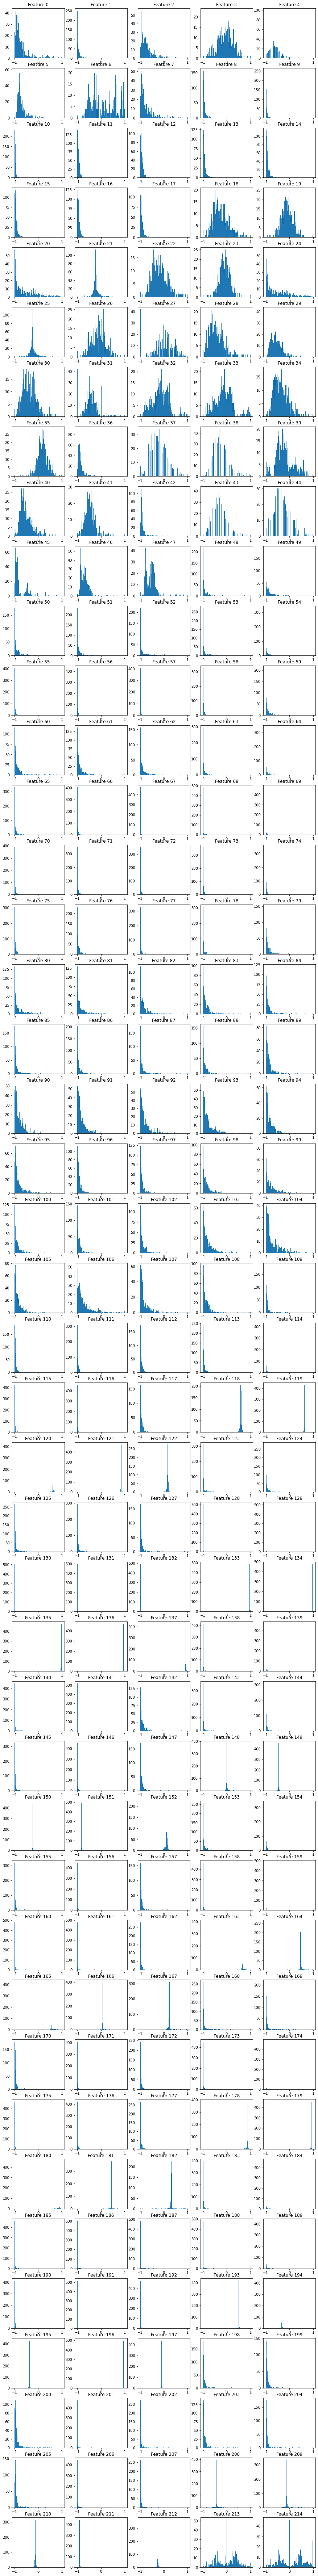

In [439]:
# See the feature distribution below of all AMIGOS features

fig, axs = plt.subplots(43, 5, figsize=(15,130))

idx = 0
for i in range(43):
    for j in range(5):
        axs[i,j].hist(amigos_data_normalized[:,idx], bins=100)
        axs[i,j].set_title("Feature {idx}".format(idx=idx))
        idx += 1

Text(0.5, 1.0, 'A Features')

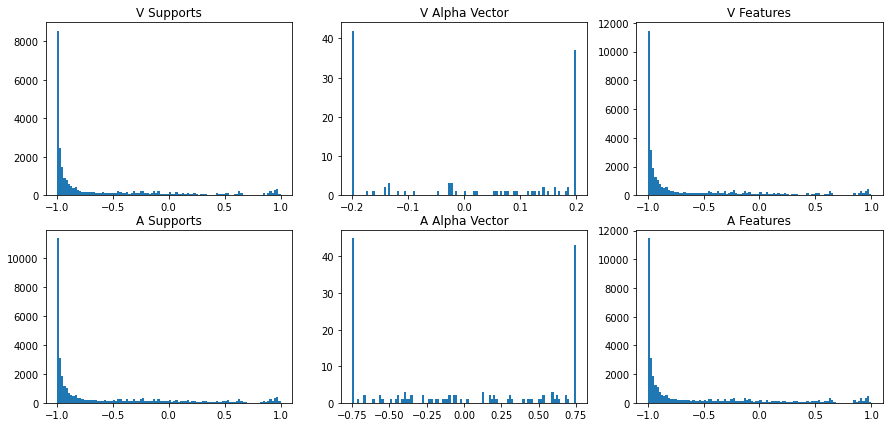

In [16]:
# If you run this with RFE=214, the distribution is quite bad (mostly on the left)
# If you run this with RFE=1, the distribution is very even because they only chose the most important features

fig, axs = plt.subplots(2,3,figsize=(15,7))

axs[0,0].hist(v_supports.ravel(), bins=100)
axs[0,0].set_title("V Supports")
axs[0,1].hist(v_alpha_vector.ravel(), bins=100)
axs[0,1].set_title("V Alpha Vector")
axs[0,2].hist(v_X_test.ravel(), bins=100)
axs[0,2].set_title("V Features")

axs[1,0].hist(a_supports.ravel(), bins=100)
axs[1,0].set_title("A Supports")
axs[1,1].hist(a_alpha_vector.ravel(), bins=100)
axs[1,1].set_title("A Alpha Vector")
axs[1,2].hist(a_X_test.ravel(), bins=100)
axs[1,2].set_title("A Features")

# Testing (Hardware friendly, quantized)

In [26]:
# This quantization method works by forcing the maximum number vector_max to be the 
# maximum value in the quantized range (eg. 127 for 8 bits with range [-127, 127]).
# Eg. if the input range was [-0.5, 0.5], 0.5 would map to 127, -0.5 maps to -127.
bits_to_quantize = 9 #n bit quantization
def quantize(vector):
    vector_max = max(map(max, vector)) # calculate max
    vector_min = min(map(min, vector)) # calculate min
    scale = (2**(bits_to_quantize-1)-1)/np.max([vector_max,vector_min])
    vector_quantized = np.round(vector*scale) # scale the weights and quantize

    return np.clip(vector_quantized, a_min=-2**(bits_to_quantize-1), a_max=2**(bits_to_quantize-1)-1), scale

v_alpha_vector_q, v_alpha_vector_scale = quantize(v_alpha_vector)
v_supports_q, v_supports_scale = quantize(v_supports)
a_alpha_vector_q, a_alpha_vector_scale = quantize(a_alpha_vector)
a_supports_q, a_supports_scale = quantize(a_supports)
v_X_test_q, v_X_test_scale = quantize(v_X_test)
a_X_test_q, a_X_test_scale = quantize(a_X_test)

In [27]:
# Printing all dimensions
print("V alpha vector shape:", v_alpha_vector_q.shape)
print("V alpha vector range :", max(v_alpha_vector_q[0]), min(v_alpha_vector_q[0]))
print("V supports shape:", v_supports_q.shape)
print("V supports range :", max(map(max, v_supports_q)), min(map(min, v_supports_q)))
print("A alpha vector shape:", a_alpha_vector_q.shape)
print("A alpha vector range :", max(a_alpha_vector_q[0]), min(a_alpha_vector_q[0]))
print("A supports shape:", a_supports_q.shape)
print("A supports range :", max(map(max, a_supports_q)), min(map(min, a_supports_q)))

V alpha vector shape: (1, 120)
V alpha vector range : 255.0 -255.0
V supports shape: (120, 214)
V supports range : 255.0 -255.0
A alpha vector shape: (1, 155)
A alpha vector range : 255.0 -255.0
A supports shape: (155, 214)
A supports range : 255.0 -255.0


Text(0.5, 1.0, 'A Features Q')

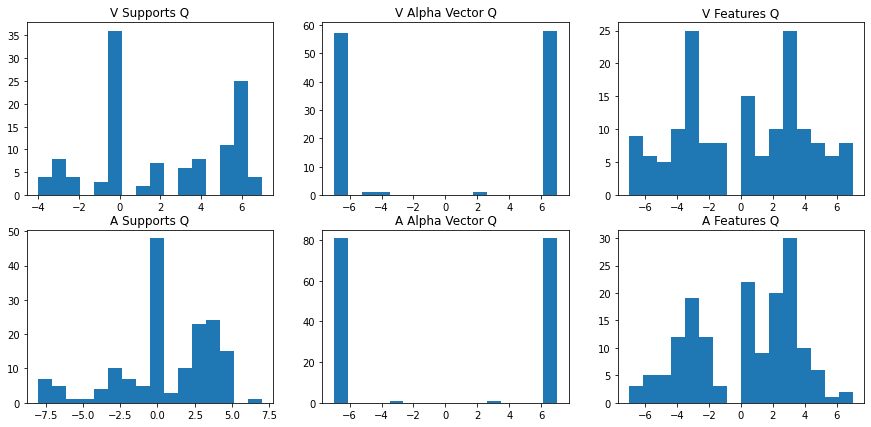

In [578]:
fig, axs = plt.subplots(2,3,figsize=(15,7))

axs[0,0].hist(v_supports_q.ravel(), bins=2**bits_to_quantize)
axs[0,0].set_title("V Supports Q")
axs[0,1].hist(v_alpha_vector_q.ravel(), bins=2**bits_to_quantize)
axs[0,1].set_title("V Alpha Vector Q")
axs[0,2].hist(v_X_test_q.ravel(), bins=2**bits_to_quantize)
axs[0,2].set_title("V Features Q")

axs[1,0].hist(a_supports_q.ravel(), bins=2**bits_to_quantize)
axs[1,0].set_title("A Supports Q")
axs[1,1].hist(a_alpha_vector_q.ravel(), bins=2**bits_to_quantize)
axs[1,1].set_title("A Alpha Vector Q")
axs[1,2].hist(a_X_test_q.ravel(), bins=2**bits_to_quantize)
axs[1,2].set_title("A Features Q")

In [41]:
v_decisions_q = np.empty([len(v_X_test_q)])

for k in range(len(v_X_test_q)):
    # First matmul
    v_kernel_dotproduct_q = np.zeros((v_supports_q.shape[0], 1))
    for i in range(v_supports_q.shape[0]):
        for j in range(v_supports_q.shape[1]):
            v_kernel_dotproduct_q[i][0] = v_kernel_dotproduct_q[i][0] + np.floor((v_supports_q[i][j] * v_X_test_q[k][j]) / 2**(bits_to_quantize))
    #     v_kernel_dotproduct_q = np.matmul(v_supports_q, v_X_test_q[k])
    
#     Quantize result of first matmul
#     for i in range(v_kernel_dotproduct_q.shape[0]):
#         v_kernel_dotproduct_q[i] = np.floor((v_kernel_dotproduct_q[i]) / 2**(np.ceil(np.log2(num_features_selected))))

# Second matmul
    v_decision2_q = 0
    for j in range(v_alpha_vector_q.shape[1]):
        v_decision2_q += v_alpha_vector_q[0][j] * v_kernel_dotproduct_q[j][0]
#     v_decision2_q = np.matmul(v_alpha_vector_q, v_kernel_dotproduct_q)
    
    # Adding intercept
    v_intercept_q = np.round(v_intercept*v_supports_scale*v_X_test_scale*v_alpha_vector_scale/2**(bits_to_quantize))

    v_decision2_q = v_decision2_q + v_intercept_q[0]
    v_decisions_q[k] = v_decision2_q

In [46]:
a_decisions_q = np.empty([len(a_X_test_q)])

for k in range(len(a_X_test_q)):
    # First matmul
    a_kernel_dotproduct_q = np.zeros((a_supports_q.shape[0], 1))
    for i in range(a_supports_q.shape[0]):
        for j in range(a_supports_q.shape[1]):
            a_kernel_dotproduct_q[i][0] = a_kernel_dotproduct_q[i][0] + np.floor((a_supports_q[i][j] * a_X_test_q[k][j]) / 2**(bits_to_quantize))
#     a_kernel_dotproduct_q = np.matmul(a_supports_q, a_X_test_q[k])

    # Quantize result of first matmul
#     for i in range(a_kernel_dotproduct_q.shape[0]):
#         a_kernel_dotproduct_q[i] = np.floor((a_kernel_dotproduct_q[i]) / 2**(np.ceil(np.log2(num_features_selected))))
        
    # Second matmul
    a_decision2_q = 0
    for j in range(a_alpha_vector_q.shape[1]):
        a_decision2_q += a_alpha_vector_q[0][j] * a_kernel_dotproduct_q[j][0]
#     a_decision2_q = np.matmul(a_alpha_vector_q, a_kernel_dotproduct_q)
    
    # Adding intercept
    a_intercept_q = np.round(a_intercept*a_supports_scale*a_X_test_scale*a_alpha_vector_scale/2**(bits_to_quantize))

    a_decision2_q = a_decision2_q + a_intercept_q[0]
    a_decisions_q[k] = a_decision2_q

In [30]:
v_y_manual = v_decisions_q > 0
# change boolean to int, then convert as list
v_y_manual = np.ndarray.tolist(v_y_manual.astype(int))
a_y_manual = a_decisions_q > 0
# change boolean to int, then convert as list
a_y_manual = np.ndarray.tolist(a_y_manual.astype(int))

In [31]:
test_v_accuracy_manual = accuracy_score(v_y_test, v_y_manual)
test_a_accuracy_manual = accuracy_score(a_y_test, a_y_manual)

print("Hardware-friendly Valence testing accuracy:", test_v_accuracy_manual)
print("Hardware-friendly Arousal testing accuracy:", test_a_accuracy_manual)

Hardware-friendly Valence testing accuracy: 0.9056603773584906
Hardware-friendly Arousal testing accuracy: 0.8553459119496856


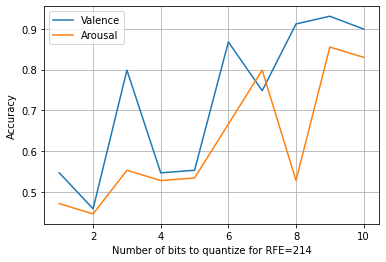

In [168]:
# Quantization with RFE=214
bits = [1,2,3,4,5,6,7,8,9,10]
v_acc_rfe214 = [0.5471698113207547,0.4591194968553459,0.7987421383647799,0.5471698113207547,0.5534591194968553,0.8679245283018868,0.7484276729559748,0.9119496855345912,0.9308176100628931,0.89937106918239]
a_acc_rfe214 = [0.4716981132075472,0.44654088050314467,0.5534591194968553,0.5283018867924528,0.5345911949685535,0.6666666666666666,0.7987421383647799,0.5283018867924528,0.8553459119496856,0.8301886792452831]

plt.plot(bits,v_acc_rfe214)
plt.plot(bits,a_acc_rfe214)
plt.xlabel('Number of bits to quantize for RFE=214')
plt.ylabel('Accuracy')
plt.legend(['Valence', 'Arousal'])
plt.grid()
plt.show()

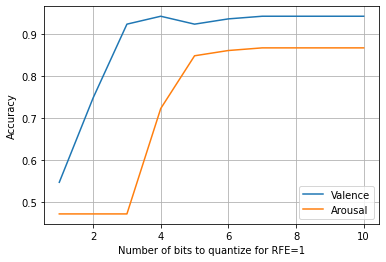

In [91]:
# Quantization with RFE=1
bits = [1,2,3,4,5,6,7,8,9,10]
v_acc_rfe1 = [0.5471698113207547,0.7484276729559748,0.9245283018867925,0.9433962264150944,0.9245283018867925,0.9371069182389937,0.9433962264150944,0.9433962264150944,0.9433962264150944,0.9433962264150944]
a_acc_rfe1 = [0.4716981132075472,0.4716981132075472,0.4716981132075472,0.7232704402515723,0.8490566037735849,0.8616352201257862,0.8679245283018868,0.8679245283018868,0.8679245283018868,0.8679245283018868]

plt.plot(bits,v_acc_rfe1)
plt.plot(bits,a_acc_rfe1)
plt.xlabel('Number of bits to quantize for RFE=1')
plt.ylabel('Accuracy')
plt.legend(['Valence', 'Arousal'])
plt.grid()
plt.show()

# Writing Files

In [52]:
f = open("tb_database/RFE_{f}_nbits_{b}_v_support.txt".format(f=num_features_selected, b=bits_to_quantize), "w")
for v_support in v_supports_q:
    for s in v_support:
        f.write(str(int(s)) + '\n')
f.close()

f = open("tb_database/RFE_{f}_nbits_{b}_v_alpha_vector.txt".format(f=num_features_selected, b=bits_to_quantize), "w")
for a in v_alpha_vector_q[0]:
    f.write(str(int(a)) + '\n')
f.close()

f = open("tb_database/RFE_{f}_nbits_{b}_v_intercept.txt".format(f=num_features_selected, b=bits_to_quantize), "w")
f.write(str(int(v_intercept_q[0])) + '\n')
f.close()

f = open("tb_database/RFE_{f}_nbits_{b}_v_features.txt".format(f=num_features_selected, b=bits_to_quantize), "w")
for v_feature in v_X_test_q:
    for x in v_feature:
        f.write(str(int(x)) + '\n')
f.close()

In [53]:
f = open("tb_database/RFE_{f}_nbits_{b}_a_support.txt".format(f=num_features_selected, b=bits_to_quantize), "w")
for a_support in a_supports_q:
    for s in a_support:
        f.write(str(int(s)) + '\n')
f.close()

f = open("tb_database/RFE_{f}_nbits_{b}_a_alpha_vector.txt".format(f=num_features_selected, b=bits_to_quantize), "w")
for a in a_alpha_vector_q[0]:
    f.write(str(int(a)) + '\n')
f.close()

f = open("tb_database/RFE_{f}_nbits_{b}_a_intercept.txt".format(f=num_features_selected, b=bits_to_quantize), "w")
f.write(str(int(a_intercept_q[0])) + '\n')
f.close()

f = open("tb_database/RFE_{f}_nbits_{b}_a_features.txt".format(f=num_features_selected, b=bits_to_quantize), "w")
for a_feature in a_X_test_q:
    for x in a_feature:
        f.write(str(int(x)) + '\n')
f.close()

In [54]:
f = open("tb_database/RFE_{f}_nbits_{b}_v_expected.txt".format(f=num_features_selected, b=bits_to_quantize), "w")
for v in v_y_manual:
    f.write(str(int(v)) + '\n')
f.close()

f = open("tb_database/RFE_{f}_nbits_{b}_a_expected.txt".format(f=num_features_selected, b=bits_to_quantize), "w")
for a in a_y_manual:
    f.write(str(int(a)) + '\n')
f.close()

# Testing with Python to see Accuracy

In [36]:
train_v_labels = v_clf.predict(v_X_train)
test_v_labels = v_clf.predict(v_X_test)
train_a_labels = a_clf.predict(a_X_train)
test_a_labels = a_clf.predict(a_X_test)

In [37]:
train_v_accuracy = accuracy_score(v_y_train, train_v_labels)
test_v_accuracy = accuracy_score(v_y_test, test_v_labels)
train_a_accuracy = accuracy_score(a_y_train, train_a_labels)
test_a_accuracy = accuracy_score(a_y_test, test_a_labels)

print("Python Valence training accuracy:", train_v_accuracy)
print("Python Arousal training accuracy:", train_a_accuracy)
print("\n")
print("Python Valence testing accuracy:", test_v_accuracy)
print("Python Arousal testing accuracy:", test_a_accuracy)

Python Valence training accuracy: 0.948509485094851
Python Arousal training accuracy: 0.8753387533875339


Python Valence testing accuracy: 0.9433962264150944
Python Arousal testing accuracy: 0.8679245283018868


# Compare hardware friendly prediction with python prediction

In [38]:
v_prediction_comparison = accuracy_score(v_y_manual, test_v_labels)
a_prediction_comparison = accuracy_score(a_y_manual, test_a_labels)

print("Valence prediction comparison:", v_prediction_comparison)
print("Arousal prediction comparison:", a_prediction_comparison)

Valence prediction comparison: 1.0
Arousal prediction comparison: 1.0
